In [110]:
import matplotlib.pyplot as plt
import numpy as np
import importlib
import os
from nems_lbhb.xform_wrappers import generate_recording_uri
from nems.recording import load_recording
from nems.epoch import epoch_names_matching
from itertools import combinations
import itertools
from sklearn.decomposition import PCA

import nems_lbhb.stateplots as sp
import nems.xform_helper as xhelp
#importlib.reload(xhelp)
import charlieTools.nat_sounds_ms.decoding as decoding
from nems_lbhb.preprocessing import pupil_large_small_masks

### load decoding results

In [111]:
#site = 'TAR017b'
site = 'DRX007a.e1:64'
site = 'TAR017b'
site = 'bbl086b'
site = 'TAR010c'

batch = 289
recache = False # For recaching decoding results locally

fig_path="/auto/users/svd/docs/current/behn_monday_2021/"

#from path_settings import DPRIME_DIR, PY_FIGURES_DIR, CACHE_PATH
DPRIME_DIR = '/auto/users/hellerc/results/nat_pupil_ms/dprime_new/'
CACHE_PATH = None # you can cache results locally, if you want...

#### load charlie results

In [112]:
X, spont_bins, X_pup, pup_mask, epochs = decoding.load_site(site=site, batch=batch, return_epoch_list=True)
ncells = X.shape[0]
nreps = X.shape[1]
nstim = X.shape[2]  # this should be = len(epochs)
nbins = X.shape[3]  # for each epoch(stim) there are nbins
nstim = nstim * nbins
# FIGURE OUT STIMULUS COMBINATION INDEXING REL TO EPOCH NAMES
# stim combos (with epoch names)
offsets = {e: v for e, v in zip(epochs, np.arange(0, nbins*nstim, nbins))}
ep_bin_str = np.concatenate([[e+'_'+str(idx+offsets[e]) for idx in range(nbins)] for e in epochs])
ep_combos = ['_'.join([c[0], c[1]]) for c in list(combinations(ep_bin_str, 2))]
# stim combos (by index #, after reshaping)
idx_combos = list(combinations(range(nstim), 2))
# LOAD DECODING RESULTS
loader = decoding.DecodingResults()
modelname = 'dprime_jk10_zscore_nclvz_fixtdr2'
fn = os.path.join(DPRIME_DIR, site, modelname+'_TDR.pickle')
results = loader.load_results(fn, cache_path=CACHE_PATH, recache=recache)

# extract results for an example epoch / index pair
#epoch1 = 'STIM_00Oxford_male2b.wav'
#epoch2 = 'STIM_00Oxford_male2b.wav'
#tbin1 = 8
#tbin2 = 18
# find the results index
#idx = str(tbin1+offsets[epoch1])+'_'+str(tbin2+offsets[epoch2])
# numeric results (d-prime, mag(dU) etc.)
#df = results.numeric_results
#ex_dprime, sem = results.get_result('dp_opt_test', stim_pair=idx, n_components=2)
# to get delta-dprime
#delta = df['bp_dp'] - df['sp_dp']
# only for evoked stimulus pairs
#d_evoked = df.loc[results.evoked_stimulus_pairs, 'dp_opt_test']

# example extraction of array results (e.g. cos(dU, noise) -- two-D because two noise dims)
# get the alignement with the first noise pc (idx = [0, None])
#cos_dU_evec_mean, cos_dU_evec_sem = results.slice_array_results(
#    'cos_dU_evec_test', results.evoked_stimulus_pairs, n_components=2, idx=[0, None])

[nems_lbhb.baphy INFO] Cached recording found: /auto/data/nems_db/recordings/289/TAR010c_fa17891b3f858333364d66bf099551dbfba310bb.tgz
[root INFO] Extracting cellids: ['TAR010c-02-1', 'TAR010c-07-2', 'TAR010c-09-2', 'TAR010c-11-1', 'TAR010c-12-2', 'TAR010c-13-1', 'TAR010c-15-4', 'TAR010c-15-5', 'TAR010c-15-6', 'TAR010c-16-1', 'TAR010c-16-2', 'TAR010c-18-2', 'TAR010c-19-3', 'TAR010c-20-1', 'TAR010c-20-2', 'TAR010c-21-3', 'TAR010c-21-4', 'TAR010c-23-1', 'TAR010c-24-2', 'TAR010c-24-3', 'TAR010c-27-3', 'TAR010c-29-1', 'TAR010c-30-3', 'TAR010c-33-3', 'TAR010c-33-4', 'TAR010c-35-2', 'TAR010c-36-1', 'TAR010c-36-2', 'TAR010c-36-3', 'TAR010c-38-2', 'TAR010c-40-1', 'TAR010c-42-2', 'TAR010c-42-3', 'TAR010c-43-2', 'TAR010c-45-1', 'TAR010c-45-2', 'TAR010c-45-3', 'TAR010c-47-1', 'TAR010c-50-1', 'TAR010c-50-2', 'TAR010c-51-1', 'TAR010c-52-2', 'TAR010c-52-3', 'TAR010c-53-1', 'TAR010c-54-2', 'TAR010c-55-1', 'TAR010c-57-1', 'TAR010c-57-2', 'TAR010c-58-2', 'TAR010c-58-3', 'TAR010c-58-4', 'TAR010c-59-1', '

In [113]:
X_ = X.reshape(ncells, nreps, nstim)
sp_ = spont_bins[0,0,:].flatten()
ev_bins = ~sp_
Xev = X_[:, :, ev_bins]
# ========================= GET FIRST PC OF EVOKED RESPONSES ============================
Xu = Xev.mean(axis=1)
spont_rates = X_[:, :, sp_].mean(axis=1).mean(axis=-1, keepdims=True)
Xu_center = Xu - spont_rates # subtract spont
pca = PCA(n_components=10)
pca.fit(Xu_center.T)
#xproj12 = X.T.dot(pca.components_[0:2, :].T)
pca.components_.shape, X.shape, site

((10, 55), (55, 24, 3, 20), 'TAR010c')

### load recordings and calc PCA axes

pc_orthog vectors are orthogonalized against the pupil_mod axis

In [114]:
import pickle
fn = '/auto/users/svd/python/nat_pupil_ms/LV/nc_zscore_lvs.pickle'
fn = '/auto/users/hellerc/results/nat_pupil_ms/LV/nc_zscore_lvs.pickle'
with open(fn, 'rb') as handle:
    lv_dict = pickle.load(handle)
pupil_mod_axis_weights = lv_dict['TAR010c']['beta2']
pupil_mod_axis_weights /= np.linalg.norm(pupil_mod_axis_weights)

pc_orthog = pca.components_[0:4, :].T
pc_orthog -= np.sum(pc_orthog * pupil_mod_axis_weights, axis=0, keepdims=True) * pupil_mod_axis_weights       # make it orthogonal to k
pc_orthog /= np.linalg.norm(pc_orthog, axis=0, keepdims=True)

print (pupil_mod_axis_weights.shape)
np.linalg.norm(pc_orthog, axis=0, keepdims=True)


(55, 1)


array([[1., 1., 1., 1.]])

#### stash projections onto pc axes into recording

Note: pc4 (4Hz) projections are orthogonalized against the pupil modulation axis!!!!

In [115]:
loadkey = "ozgf.fs100.ch18.pup"
uri = generate_recording_uri(cellid=site,batch=batch,loadkey=loadkey)
rec = load_recording(uri)
rec['resp']=rec['resp'].rasterize()

r0 = rec.copy()
r0 = r0.create_mask('PreStimSilence').apply_mask()
sp = r0['resp'].as_continuous().mean(axis=1, keepdims=True)

r = rec['resp']._data - sp
pc = r.T.dot(pca.components_[0:4, :].T).T
rec['pc']=rec['resp']._modified_copy(data=pc, name='pc')

r = rec['resp']._data.copy()
r -= r.mean(axis=1,keepdims=True)
r /= r.std(axis=1, keepdims=True)
pupil_mod = r.T.dot(pupil_mod_axis_weights).T
rec['pupil_mod']=rec['resp']._modified_copy(data=pupil_mod, name='pupil_mod')

rec = pupil_large_small_masks(rec)['rec']

loadkey = "psth.fs4.pup"
uri = generate_recording_uri(cellid=site,batch=batch,loadkey=loadkey)
rec4 = load_recording(uri)

from nems_lbhb.preprocessing import mask_high_repetion_stims
rec4['resp']=rec4['resp'].rasterize()

r0 = rec4.copy()
r0 = r0.create_mask('PreStimSilence').apply_mask()
sp = r0['resp'].as_continuous().mean(axis=1, keepdims=True)

r = rec4['resp']._data - sp
#pc = r.T.dot(pca.components_[0:4, :].T).T
pc = r.T.dot(pc_orthog).T

rec4['pc']=rec4['resp']._modified_copy(data=pc, name='pc')
r = rec4['resp']._data.copy()
r -= r.mean(axis=1,keepdims=True)
r /= r.std(axis=1, keepdims=True)
pupil_mod = r.T.dot(pupil_mod_axis_weights).T
rec4['pupil_mod']=rec4['resp']._modified_copy(data=pupil_mod, name='pupil_mod')

rec4 = mask_high_repetion_stims(rec4)
rec4 = pupil_large_small_masks(rec4)['rec']

# get list of stim included in the decoder, sorted as in original recording
decoded_stimnames = set(offsets.keys())
stimnames = [s for s in epoch_names_matching(rec['resp'].epochs, "^STIM_") if s in decoded_stimnames]


[nems_lbhb.xform_wrappers INFO] loader=ozgf.fs100.ch18.pup
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/289/TAR010c_fa81ed8c626508ad52e4912ce5117ff3d6ae4f75.tgz
[nems_lbhb.preprocessing INFO] creating pupil mask with options: {'state': 'big', 'epoch': ['REFERENCE'], 'collapse': True}
[nems_lbhb.preprocessing INFO] collapsing over all ['REFERENCE'] epochs and tiling mean pupil per epoch
[nems_lbhb.preprocessing INFO] creating pupil mask with options: {'state': 'small', 'epoch': ['REFERENCE'], 'collapse': True}
[nems_lbhb.preprocessing INFO] collapsing over all ['REFERENCE'] epochs and tiling mean pupil per epoch
[nems_lbhb.xform_wrappers INFO] loader=psth.fs4.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/289/TAR010c_8d49f3692702af53dbb092f8e8f3f51843d1d41e.tgz
[nems_lbhb.preprocessing INFO] creating pupil mask with options: {'state': 'big', 'epoch':

In [116]:
decoded_stimnames = set(offsets.keys())
stimnames = [s for s in epoch_names_matching(rec['resp'].epochs, "^STIM_") if s in decoded_stimnames]
stimnames

['STIM_00Oxford_male2b.wav',
 'STIM_00ferretmixed41.wav',
 'STIM_00ferretmixed42.wav']

### generate confusion matrix and associated stim/response data

In [117]:
#e=stimnames[1]
#print(f"extracting data for epoch {e}")

spont_count = spont_bins[0,0,0,:].sum()
total_count = spont_bins.shape[3]
bins_per_stim = total_count-spont_count+1

df = results.numeric_results
df['delta'] = df['bp_dp'] - df['sp_dp']

bin_range = [['spont'] + [str(t+offsets[e]) for t in range(spont_count,total_count)] for e in stimnames]
bin_range = list(itertools.chain.from_iterable(bin_range))

stats = ['bp_dp', 'sp_dp', 'delta']
confusions = np.zeros((len(stats), len(bin_range), len(bin_range)))
for i,s in enumerate(stats):
    for j,b1 in enumerate(bin_range):
        for k,b2 in enumerate(bin_range):
            if j<k:
                idx = b1+"_"+b2
                try:
                    confusions[i,j,k]=df.loc[idx,2][s]
                    confusions[i,k,j]=df.loc[idx,2][s]
                except:
                    idx = b2+"_"+b1
                    confusions[i,j,k]=df.loc[idx,2][s]
                    confusions[i,k,j]=df.loc[idx,2][s]
     
                
stim = {e: rec['stim']._data[e][:,((spont_count-1)*25):(total_count*25)] for e in stimnames}
pc = {e: rec['pc'].extract_epoch(e)[:,:,((spont_count-1)*25):(total_count*25)] for e in stimnames}
pc4 = {e: rec4['pc'].extract_epoch(e)[:,:,(spont_count-1):total_count] for e in stimnames}
pmod4 = {e: rec4['pupil_mod'].extract_epoch(e)[:,:,(spont_count-1):total_count] for e in stimnames}

rec_=rec4.copy()
rec_['mask']=rec_['mask_large']
pc_large = {e: rec_.apply_mask()['pc'].extract_epoch(e)[:,:,(spont_count-1):total_count] for e in stimnames}
pmod_large = {e: rec_.apply_mask()['pupil_mod'].extract_epoch(e)[:,:,(spont_count-1):total_count] for e in stimnames}
rec_=rec4.copy()
rec_['mask']=rec_['mask_small']
pc_small = {e: rec_.apply_mask()['pc'].extract_epoch(e)[:,:,(spont_count-1):total_count] for e in stimnames}
pmod_small = {e: rec_.apply_mask()['pupil_mod'].extract_epoch(e)[:,:,(spont_count-1):total_count] for e in stimnames}

pc_mag={e: np.sqrt(np.mean(np.mean(pc[e], axis=0, keepdims=True)**2, axis=1)) for e in stimnames}
pc4_mag={e: np.sqrt(np.mean(np.mean(pc4[e], axis=0, keepdims=True)**2, axis=1)) for e in stimnames}
pc_var={e: np.sqrt(np.mean(np.std(pc[e], axis=0, keepdims=True)**2, axis=1)) for e in stimnames}
pc4_var={e: np.sqrt(np.mean(np.std(pc4[e], axis=0, keepdims=True)**2, axis=1)) for e in stimnames}

pc_mag_small={e: np.sqrt(np.mean(np.mean(pc_small[e], axis=0, keepdims=True)**2, axis=1)) for e in stimnames}
pc_mag_large={e: np.sqrt(np.mean(np.mean(pc_large[e], axis=0, keepdims=True)**2, axis=1)) for e in stimnames}
pc_var_small={e: np.sqrt(np.mean(np.std(pc_small[e], axis=0, keepdims=True)**2, axis=1)) for e in stimnames}
pc_var_large={e: np.sqrt(np.mean(np.std(pc_large[e], axis=0, keepdims=True)**2, axis=1)) for e in stimnames}

In [118]:
pc_small[e].shape


(10, 4, 13)

#### ellipse plots in PC vs. pupil_mod space

plot a bunch of ellipse plots for big/small pupil, sampling a bunch of pairs from a row of the confusion matrix

Text(0.5, 0, 'PC0 proj')

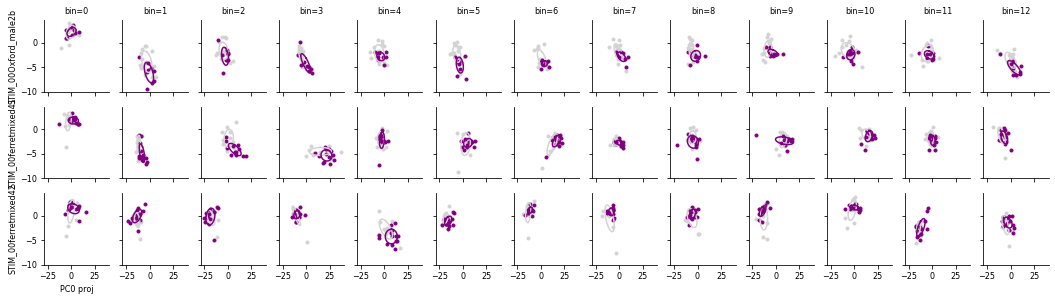

In [119]:
from charlieTools.plotting import compute_ellipse
f,ax=plt.subplots(3,13,figsize=(18,4.5),sharex=True,sharey=True)

pcidx=0
for ei in range(3):
    e=stimnames[ei]
    for i in range(13):
        ax[ei,i].plot(pc_small[e][:,pcidx,i],pmod_small[e][:,0,i],'.', color='lightgray')
        ax[ei,i].plot(pc_large[e][:,pcidx,i],pmod_large[e][:,0,i],'.', color='purple')
        #ax[ei,i].plot(np.mean(pc_small[e][:,:,i]**2,axis=1), pmod_small[e][:,0,i],'.')
        #ax[ei,i].plot(np.mean(pc_large[e][:,:,i]**2,axis=1), pmod_large[e][:,0,i],'.')
        ex,ey=compute_ellipse(pc_small[e][:,pcidx,i],pmod_small[e][:,0,i])
        ax[ei,i].plot(ex,ey,color='lightgray')
        ex,ey=compute_ellipse(pc_large[e][:,pcidx,i],pmod_large[e][:,0,i])
        ax[ei,i].plot(ex,ey,color='purple')
        if ei==0:
            ax[ei,i].set_title(f"bin={i}")
    ax[ei,0].set_ylabel(e.split('.')[0])
ax[2,0].set_xlabel(f"PC{pcidx} proj")

#### alt approach: plot all the ellipses in one plot per pupil condition

Text(0.5, 1.0, 'large')

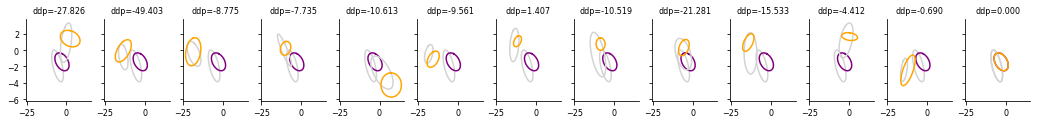

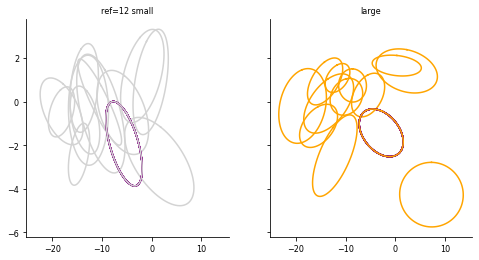

In [120]:
#importlib.reload(decoding)
from charlieTools.plotting import compute_ellipse

ei=2  # propogate from previous cell
e=stimnames[ei]

binsets = [[2,10],[2,11]]
binsets = [[1,7],[1,2]]
binsets = [[5,12],[6,12],[7,12],[8,12]]
binsets = [[5,9],[5,10],[5,11],[5,12]]

f, ax = plt.subplots(1,13,figsize=(18,1.5),sharex=True,sharey=True)
f2, ax2 = plt.subplots(1,2,figsize=(8,4),sharex=True,sharey=True)
pcidx=0
ref_idx=12
for i in range(13):
    
    ex,ey=compute_ellipse(pc_small[e][:,pcidx,ref_idx],pmod_small[e][:,0,ref_idx])
    ax[i].plot(ex,ey,color='lightgray')
    ax2[0].plot(ex,ey,color='purple')
    ex,ey=compute_ellipse(pc_large[e][:,pcidx,ref_idx],pmod_large[e][:,0,ref_idx])
    ax[i].plot(ex,ey,color='purple')
    ax2[1].plot(ex,ey,color='purple')

    ex,ey=compute_ellipse(pc_small[e][:,pcidx,i],pmod_small[e][:,0,i])
    ax[i].plot(ex,ey,color='lightgray')
    ax2[0].plot(ex,ey,color='lightgray')
    ex,ey=compute_ellipse(pc_large[e][:,pcidx,i],pmod_large[e][:,0,i])
    ax[i].plot(ex,ey,color='orange')
    ax2[1].plot(ex,ey,color='orange')

    ax[i].set_title(f"ddp={confusions[2,ref_idx,i]:.3f}")
    
ax2[0].set_title(f'ref={ref_idx} small')
ax2[1].set_title('large')
#print(fig_path+"example_pairs_"+site+"_"+e.split(".")[0]+".pdf")
#f.savefig(fig_path+"example_pairs_"+site+"_"+e.split(".")[0]+".pdf")

### confusion matrix for one natural sound

/auto/users/svd/docs/current/behn_monday_2021/confusion_TAR010c_STIM_00ferretmixed42.pdf


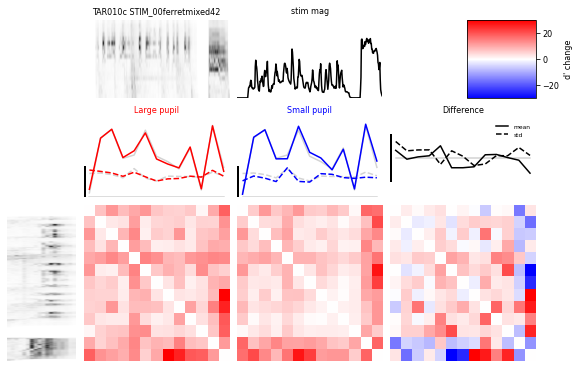

In [121]:
ei=2
e=stimnames[ei]
erange=slice(ei*bins_per_stim, (ei+1)*bins_per_stim)

f = plt.figure(constrained_layout=True,figsize=(9,5))
gs = f.add_gridspec(4,8)
ax = [f.add_subplot(gs[2:,((i+1)*2):((i+1)*2+2)]) for i in range(3)]
ax_sg = f.add_subplot(gs[0,2:4])
ax_sg2 = f.add_subplot(gs[2:,1])
ax_sg_var = f.add_subplot(gs[0,4:6])

ax_resp_lg = f.add_subplot(gs[1,2:4])
ax_resp_sm = f.add_subplot(gs[1,4:6])
ax_resp_diff = f.add_subplot(gs[1,6:8])
ax_cb = f.add_subplot(gs[0,-1])

clims = np.array([[-60,60],[-60,60],[-30,30]])
fs=4
delta=1/(2*fs)
extent=[-delta, confusions.shape[1]/fs-delta, -delta, confusions.shape[1]/fs-delta]
for i in range(3):
    im=ax[i].imshow(confusions[i,erange,erange], aspect='auto', clim=clims[i], cmap='bwr', extent=extent)
    #ax[i].set_title(stats[i])
    ax[i].axis('off')

plt.colorbar(im, cax=ax_cb, label="d' change")

ax_sg.imshow(np.sqrt(stim[e]),aspect='auto',origin='lower',cmap='gray_r')
ax_sg.axis('off')
ax_sg.set_title(site + " " + e.split(".")[0])

ax_sg2.imshow(np.sqrt(stim[e].T),aspect='auto',cmap='gray_r')
ax_sg2.axis('off')

ax_sg_var.plot(np.sqrt(stim[e]).mean(axis=0), 'k')
#ax_sg_var.plot([0,0],[0, 10],'k-', linewidth=3)
ax_sg_var.axis('off')
ax_sg_var.set_xlim([0, stim[e].shape[1]])
ax_sg_var.set_ylim([0, 3])
ax_sg_var.set_title('stim mag')

H=5
Ymax=np.ceil(np.max([pc_mag_large[e].max(), pc_mag_small[e].max()]))

ax_resp_lg.plot(pc4_mag[e].mean(axis=0).T, color='lightgray', label="all")
ax_resp_lg.plot(pc4_var[e].mean(axis=0).T, '--', color='lightgray', label="all")
ax_resp_lg.plot([0, pc_mag_large[e].shape[1]-1],[0,0],'-', color='lightgray')
ax_resp_lg.plot([-0.5,-0.5],[0, H],'k-', linewidth=3)
ax_resp_lg.plot(pc_mag_large[e].mean(axis=0).T, color='red', label="lg")
ax_resp_lg.plot(pc_var_large[e].mean(axis=0).T, '--', color='red')
ax_resp_lg.axis('off')
ax_resp_lg.set_xlim([-0.5, pc_mag_large[e].shape[1]-0.5])
ax_resp_lg.set_ylim([0, Ymax])
ax_resp_lg.set_title('Large pupil', color='red')

ax_resp_sm.plot(pc4_mag[e].mean(axis=0).T, color='lightgray', label="all")
ax_resp_sm.plot(pc4_var[e].mean(axis=0).T, '--', color='lightgray', label="all")
ax_resp_sm.plot([0, pc_mag_large[e].shape[1]-1],[0,0],'-', color='lightgray')
ax_resp_sm.plot([-0.5,-0.5],[0, H],'k-', linewidth=3)
ax_resp_sm.plot(pc_mag_small[e].mean(axis=0).T, color='blue', label='sm')
ax_resp_sm.plot(pc_var_small[e].mean(axis=0).T, '--', color='blue')
ax_resp_sm.axis('off')
ax_resp_sm.set_xlim([-0.5, pc_mag_large[e].shape[1]-0.5])
ax_resp_sm.set_ylim([0, Ymax])
ax_resp_sm.set_title('Small pupil', color='blue');

ax_resp_diff.plot([0, pc_mag_large[e].shape[1]-1],[0,0], '-', color='lightgray')
ax_resp_diff.plot([-0.5,-0.5],[-H/2, H/2],'k-', linewidth=3)
ax_resp_diff.plot((pc_mag_large[e]-pc_mag_small[e]).mean(axis=0).T, color='black', label='mean')
ax_resp_diff.plot((pc_var_large[e]-pc_var_small[e]).mean(axis=0).T, '--', color='black', label='std')
ax_resp_diff.axis('off')
ax_resp_diff.set_xlim([-0.5, pc_mag_large[e].shape[1]-0.5])
ax_resp_diff.set_ylim([-Ymax/3, Ymax/3])
ax_resp_diff.set_title('Difference');
ax_resp_diff.legend(frameon=False)

#print(fig_path+"confusion_"+site+"_"+e.split(".")[0]+".pdf")
#f.savefig(fig_path+"confusion_"+site+"_"+e.split(".")[0]+".pdf")

### ellipse plots to point to examples in he confusion matrix

[nems_lbhb.baphy INFO] Cached recording found: /auto/data/nems_db/recordings/289/TAR010c_fa17891b3f858333364d66bf099551dbfba310bb.tgz
[root INFO] Extracting cellids: ['TAR010c-02-1', 'TAR010c-07-2', 'TAR010c-09-2', 'TAR010c-11-1', 'TAR010c-12-2', 'TAR010c-13-1', 'TAR010c-15-4', 'TAR010c-15-5', 'TAR010c-15-6', 'TAR010c-16-1', 'TAR010c-16-2', 'TAR010c-18-2', 'TAR010c-19-3', 'TAR010c-20-1', 'TAR010c-20-2', 'TAR010c-21-3', 'TAR010c-21-4', 'TAR010c-23-1', 'TAR010c-24-2', 'TAR010c-24-3', 'TAR010c-27-3', 'TAR010c-29-1', 'TAR010c-30-3', 'TAR010c-33-3', 'TAR010c-33-4', 'TAR010c-35-2', 'TAR010c-36-1', 'TAR010c-36-2', 'TAR010c-36-3', 'TAR010c-38-2', 'TAR010c-40-1', 'TAR010c-42-2', 'TAR010c-42-3', 'TAR010c-43-2', 'TAR010c-45-1', 'TAR010c-45-2', 'TAR010c-45-3', 'TAR010c-47-1', 'TAR010c-50-1', 'TAR010c-50-2', 'TAR010c-51-1', 'TAR010c-52-2', 'TAR010c-52-3', 'TAR010c-53-1', 'TAR010c-54-2', 'TAR010c-55-1', 'TAR010c-57-1', 'TAR010c-57-2', 'TAR010c-58-2', 'TAR010c-58-3', 'TAR010c-58-4', 'TAR010c-59-1', '

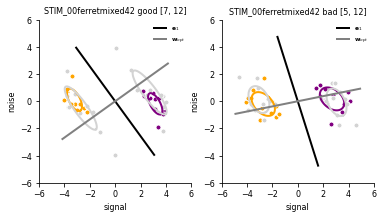

In [122]:
#importlib.reload(decoding)

#ei=2  # propogate from previous cell
e=stimnames[ei].split('.')[0]

binsets = [[2,10],[2,11]]
binsets = [[1,7],[1,2]]
binsets = [[7,12],[5,12]]

f,ax = plt.subplots(1,2,figsize=(6,3))

binlabels = [f"{e} good {binsets[0]}", 
             f"{e} bad {binsets[1]}"]
ylim=[-6,6]
xlim=[-6,6]

for i,b in enumerate(binsets):

    pair, site, batch = (int(bin_range[int(ei*bins_per_stim+b[0])]),int(bin_range[int(ei*bins_per_stim+b[1])])), site, 289
    decoding.plot_stimulus_pair(site,
                                batch, 
                                pair,
                                colors=['purple','orange'],
                                axlabs=['signal','noise'],
                                pup_split=True,
                                ylim=ylim,
                                xlim=xlim,
                                ellipse=True,
                                ax_length=5,
                                ax=ax[i])
    ax[i].set_title(binlabels[i], fontsize=8)
    
#print(fig_path+"example_pairs_"+site+"_"+e.split(".")[0]+".pdf")
#f.savefig(fig_path+"example_pairs_"+site+"_"+e.split(".")[0]+".pdf")

### confusion matrix for all natural sounds

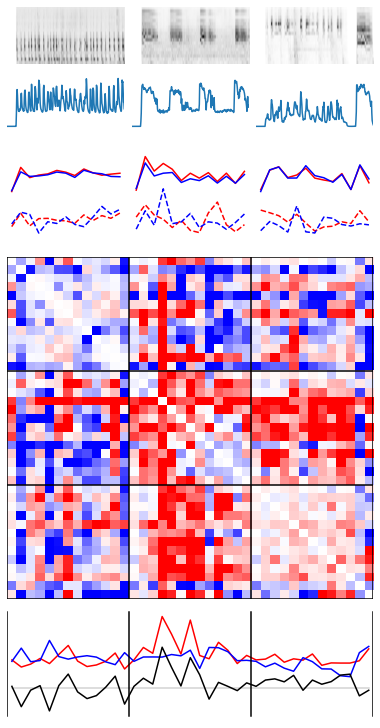

In [123]:
stimcount = len(stimnames)

f = plt.figure(constrained_layout=True,figsize=(7, 10))

gs = f.add_gridspec((stimcount+3)*2,(stimcount+1)*2)
ax_confusion = f.add_subplot(gs[4:10,2:])
ax_confusion_avg = f.add_subplot(gs[10:,2:])
ax_sg = [f.add_subplot(gs[0,(i*2+2):(i*2+4)]) for i in range(stimcount)]
ax_sg_mag = [f.add_subplot(gs[1,(i*2+2):(i*2+4)]) for i in range(stimcount)]
ax_resp = [f.add_subplot(gs[2:4,(i*2+2):(i*2+4)]) for i in range(stimcount)]

stat_id=2
#ax_confusion.imshow(confusions[stat_id,:,:], aspect='equal', clim=clims[i], cmap='bwr', extent=extent)
ax_confusion.imshow(confusions[stat_id,:,:], aspect='auto', clim=clims[stat_id], cmap='bwr', extent=[0,stimcount,0,stimcount])
ax_confusion.axis('off')
    
ax_confusion_avg.plot([0, confusions.shape[1]-1],[0, 0],color='lightgray')
ax_confusion_avg.plot(confusions[0,:,:].mean(axis=0), color='red')
ax_confusion_avg.plot(confusions[1,:,:].mean(axis=0), color='blue')
ax_confusion_avg.plot(confusions[stat_id,:,:].mean(axis=0), color='black')
ax_confusion_avg.set_xlim([-0.5, confusions.shape[1]-0.5])
ax_confusion_avg.axis('off')
yl=ax_confusion_avg.get_ylim()

for i in range(len(stimnames)+1):
    ax_confusion.plot([0,stimcount],[i ,i],'k-')
    ax_confusion.plot([i ,i],[0,stimcount],'k-')
    
    ax_confusion_avg.plot([i*bins_per_stim-0.5, i*bins_per_stim-0.5], yl, 'k-')

for i,e in enumerate(stimnames):
    ax_sg[i].imshow(np.sqrt(stim[e]),aspect='auto',origin='lower',cmap='gray_r')
    ax_sg[i].axis('off')
    
    ax_sg_mag[i].plot(np.sqrt(stim[e]).mean(axis=0))
    #ax_sg_mag[i].plot([0,0],[0, 25],'k-')
    ax_sg_mag[i].axis('off')
    ax_sg_mag[i].set_xlim([-0.5, stim[e].shape[1]-0.5])
    ax_sg_mag[i].set_ylim([-0.1, 3])
    
    #ax_resp[i].plot(pc_mag[e].mean(axis=0).T)
    #ax_resp[i].plot([0,0],[0,1],'k-')
    ax_resp[i].plot(pc_mag_large[e].mean(axis=0).T/5+6, color='red', label="lg")
    ax_resp[i].plot(pc_mag_small[e].mean(axis=0).T/5+6, color='blue', label='sm')
    ax_resp[i].plot(pc_var_large[e].mean(axis=0).T, '--', color='red', label="lg_var")
    ax_resp[i].plot(pc_var_small[e].mean(axis=0).T, '--', color='blue', label="sm_var")
    ax_resp[i].axis('off')
    ax_resp[i].set_xlim([-0.5, pc_mag_large[e].shape[1]-0.5])
    ax_resp[i].set_ylim([1, 11])

#print(fig_path+"confusion_"+site+"_all.pdf")
#f.savefig(fig_path+"confusion_"+site+"_all.pdf")

Text(0.5, 0, 'resp std')

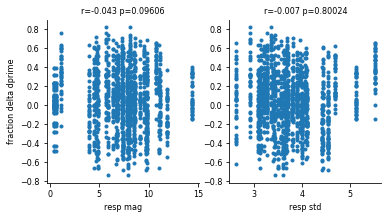

In [124]:
from scipy.stats import pearsonr

biglist=[v for k,v in pc4_mag.items()]
pc_mag_all = np.concatenate([v for k,v in pc4_mag.items()], axis=1)
pc_var_all = np.concatenate([v for k,v in pc4_var.items()], axis=1)

pc_mag_all.shape, pc_var_all.shape, confusions.shape

mag = np.tile(pc_mag_all,[confusions.shape[1], 1])
var = np.tile(pc_var_all,[confusions.shape[1], 1])

conf = confusions[2,:,:]/(confusions[0:2,:,:].sum(axis=0) + (confusions[0:2,:,:].mean(axis=0)==0))

f,ax = plt.subplots(1,2,figsize=(6,3))
ax[0].plot(mag.flatten(), conf.flatten(), '.')
r,p = pearsonr(mag[np.abs(conf)>0].flatten(), conf[np.abs(conf)>0].flatten())
ax[0].set_title(f"r={r:.3f} p={p:.5f}")
ax[0].set_xlabel('resp mag')
ax[0].set_ylabel('fraction delta dprime')

ax[1].plot(var.flatten(), conf.flatten(), '.');
r,p = pearsonr(var[np.abs(conf)>0].flatten(), conf[np.abs(conf)>0].flatten())
ax[1].set_title(f"r={r:.3f} p={p:.5f}")
ax[1].set_xlabel('resp std')


### sm pup vs. larg pup scatter

In [125]:
cd /auto/users/svd/python/nat_pup_ms


/auto/users/svd/python/nat_pup_ms


[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_new/BOL005c/dprime_jk10_zscore_nclvz_fixtdr2_TDR.pickle
/home/svd/bin/miniconda3/envs/tf_test/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_new/BOL006b/dprime_jk10_zscore_nclvz_fixtdr2_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_new/TAR010c/dprime_jk10_zscore_nclvz_fixtdr2_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_new/TAR017b/dprime_jk10_zscore_nclvz_fixtdr2_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dpr

/auto/users/svd/docs/current/behn_monday_2021/dprime_scatter.pdf


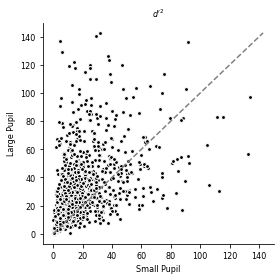

In [126]:
#from path_settings import DPRIME_DIR, PY_FIGURES_DIR, CACHE_PATH
from global_settings import ALL_SITES, LOWR_SITES, HIGHR_SITES, NOISE_INTERFERENCE_CUT, DU_MAG_CUT
import colors as color
import ax_labels as alab

import charlieTools.nat_sounds_ms.decoding as decoding

from scipy.stats import gaussian_kde
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

loader = decoding.DecodingResults()
modelname = 'dprime_jk10_zscore_nclvz_fixtdr2'
max_dp=150

# subsample results
nSamples = 1000
np.random.seed(123)

density = False  # density scatter plot
ALL_TRAIN_DATA = False
sites = HIGHR_SITES
path = DPRIME_DIR

df = []
for site in sites:
    if (site in LOWR_SITES) | (ALL_TRAIN_DATA): mn = modelname.replace('_jk10', '_jk1_eev') 
    else: mn = modelname
    fn = os.path.join(path, site, mn+'_TDR.pickle')
    results = loader.load_results(fn, cache_path=CACHE_PATH, recache=recache)
    _df = results.numeric_results.loc[pd.IndexSlice[results.evoked_stimulus_pairs, 2], :]
    _df['site'] = site
    df.append(_df)

df = pd.concat(df)

df = df.loc[(df.bp_dp<max_dp)&(df.sp_dp<max_dp)]

idx = np.random.choice(range(df.shape[0]), nSamples, replace=False)
bp = df.iloc[idx]['bp_dp']
sp = df.iloc[idx]['sp_dp']

s = 15
m = pd.concat([bp, sp]).max()
f, ax = plt.subplots(1, 1, figsize=(4, 4))

if density:
    xy = np.vstack([bp.values, sp.values])
    z = gaussian_kde(xy)(xy)
    ax.scatter(sp, bp, s=s, c=z)
else:
    ax.scatter(sp, bp, s=s, color='k', edgecolor='white')
ax.plot([0, m], [0, m], color='grey', linestyle='--')

ax.set_xlabel('Small Pupil')
ax.set_ylabel('Large Pupil')
ax.set_title(r"$d'^2$")

f.tight_layout()

print(fig_path+"dprime_scatter.pdf")
f.savefig(fig_path+"dprime_scatter.pdf")